In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath('..'))
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets, VBox, HBox
import numpy as np
from torch.utils.data import DataLoader, random_split
import random
from src.dataset import ProjectDatasets
from src.models.UNet import UNet
from src.utils.helpers import visualize_batch_with_colorbar
from torchvision.transforms import Compose, ToTensor, Normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
checkpoints_path = "/net/travail/rramesh/AdvanceimageProcessing/Semantic-Segmentation-for-Autonomous-Driving/experiments/checkpoint_epoch_10.pth"

transform = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5])])
dataset = ProjectDatasets(root_path="/net/ens/am4ip/datasets/project-dataset", transform=transform)

model = UNet(in_channels=3, out_channels=30)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Pre-warm CUDA
if torch.cuda.is_available():
    _ = torch.randn(1).to(device)

checkpoint = torch.load(checkpoints_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])


/tmp/cache-rramesh/ipykernel_2464468/3907763748.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path, map_location=device)


<All keys matched successfully>

In [3]:
# Split dataset
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(seed)
_, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

In [4]:
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [5]:
# for batch_idx, (inputs, targets, _) in enumerate(val_loader):
#     with torch.no_grad():
#         inputs, targets = inputs.to(device), targets.to(device)
#         predictions = model(inputs)
#         predictions = torch.argmax(predictions, dim=1)  # Assuming output is logits
        
#         print(f"The shape of the prediction is {predictions.shape}")  
#        # Check intensity range of predictions
#         max_intensity = torch.max(predictions).item()
#         min_intensity = torch.min(predictions).item()
#         print(f"The maximum intensity of the prediction is {max_intensity} and the minimum is {min_intensity}")
        
#     visualize_batch_with_colorbar(inputs, predictions, targets, batch_idx, num_samples=3)
#     break# Visualize only the first batch

# Mapping RGB pixel in prediction

In [6]:
# Reverse the color_to_class mapping to get class_to_color mapping
color_to_class = {
    (0, 0, 0): 0,            # Unlabeled
    (111, 74, 0): 1,         # Dynamic
    (81, 0, 81): 2,          # Ground
    (128, 64, 128): 3,       # Road
    (244, 35, 232): 4,       # Sidewalk
    (250, 170, 160): 5,      # Parking
    (230, 150, 140): 6,      # Rail track
    (70, 70, 70): 7,         # Building
    (102, 102, 156): 8,      # Wall
    (190, 153, 153): 9,      # Fence
    (180, 165, 180): 10,     # Guard rail
    (150, 100, 100): 11,     # Bridge
    (150, 120, 90): 12,      # Tunnel
    (153, 153, 153): 13,     # Pole
    (250, 170, 30): 14,      # Traffic light
    (220, 220, 0): 15,       # Traffic sign
    (107, 142, 35): 16,      # Vegetation
    (152, 251, 152): 17,     # Terrain
    (70, 130, 180): 18,      # Sky
    (220, 20, 60): 19,       # Person
    (255, 0, 0): 20,         # Rider
    (0, 0, 142): 21,         # Car
    (0, 0, 70): 22,          # Truck
    (0, 60, 100): 23,        # Bus
    (0, 0, 90): 24,          # Caravan
    (0, 0, 110): 25,         # Trailer
    (0, 80, 100): 26,        # Train
    (0, 0, 230): 27,         # Motorcycle
    (119, 11, 32): 29        # Bicycle
}

class_to_color = {v: k for k, v in color_to_class.items()}

def map_classes_to_colors(predictions, class_to_color):
    """
    Map class IDs to RGB colors for a segmentation map.

    Args:
        predictions (torch.Tensor): Tensor of shape (H, W) containing class IDs.
        class_to_color (dict): Mapping from class IDs to RGB colors.

    Returns:
        np.ndarray: RGB image of shape (H, W, 3).
    """
    height, width = predictions.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_id, color in class_to_color.items():
        rgb_image[predictions == class_id] = color  # Map each class to its color
    
    return rgb_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the shape of the targets is torch.Size([8, 256, 256])
the shape of the inputs is torch.Size([8, 3, 256, 256])


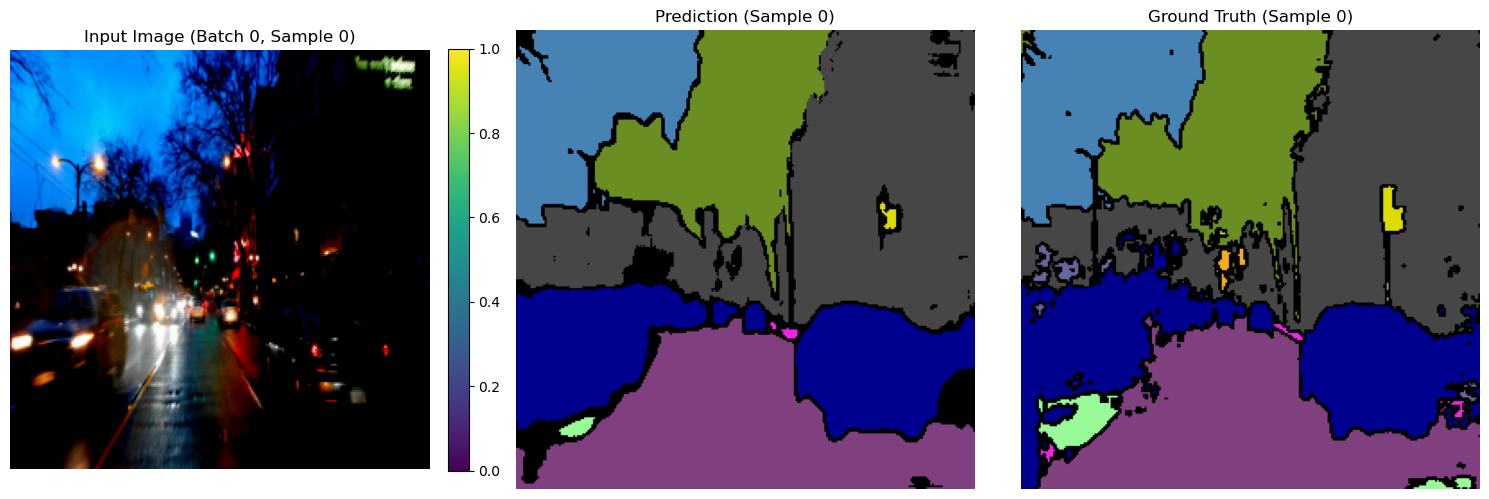

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


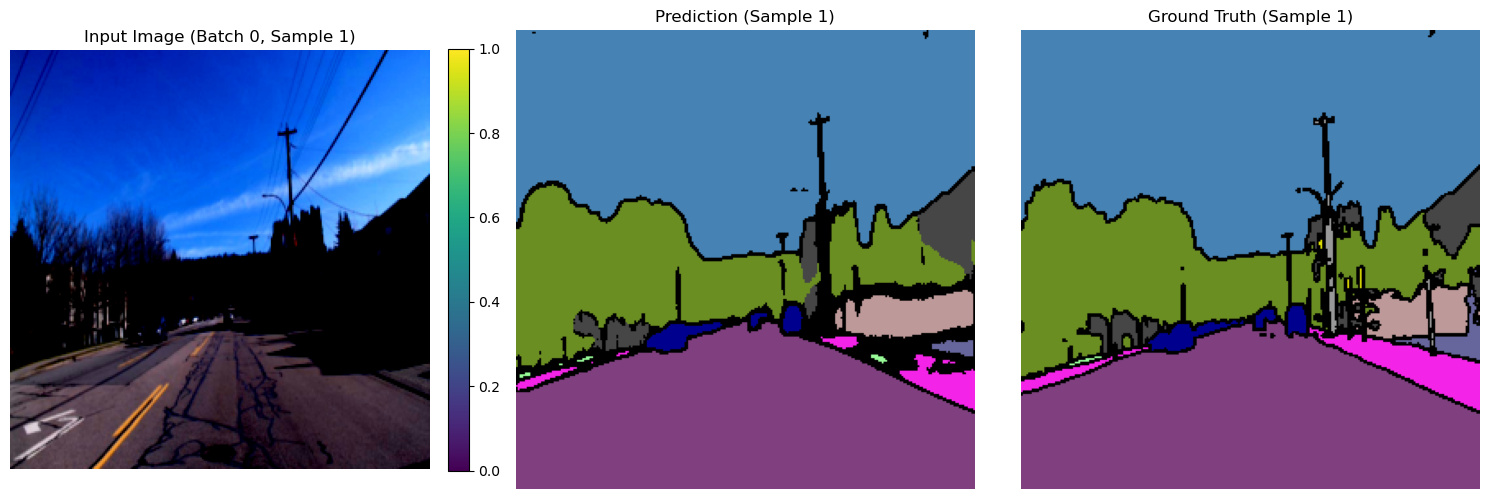

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


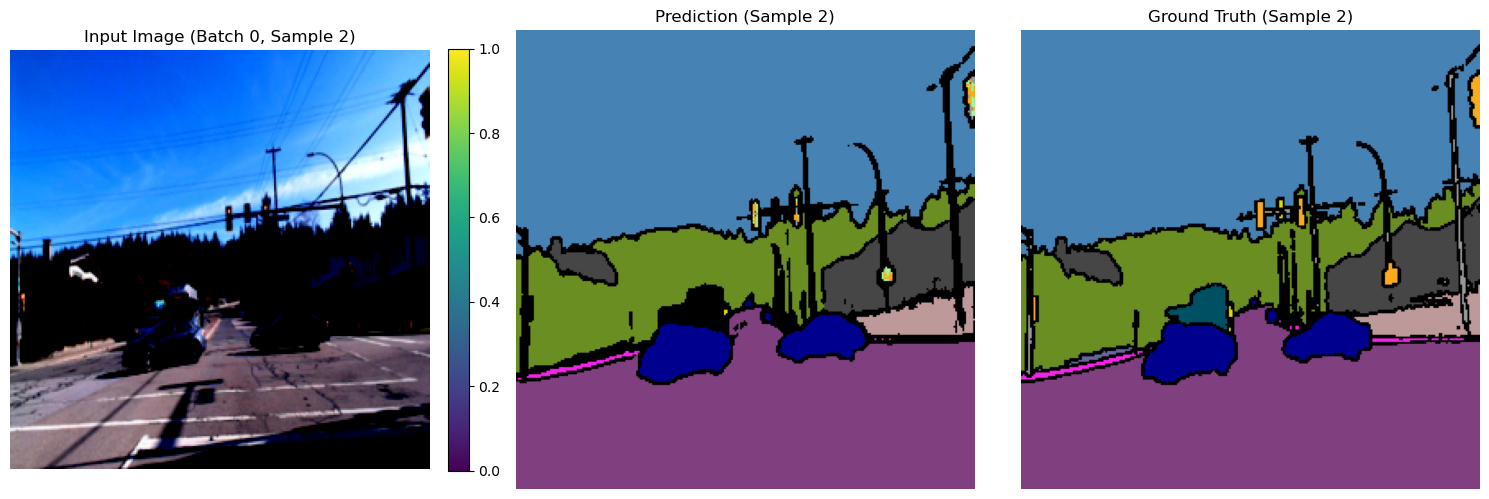

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


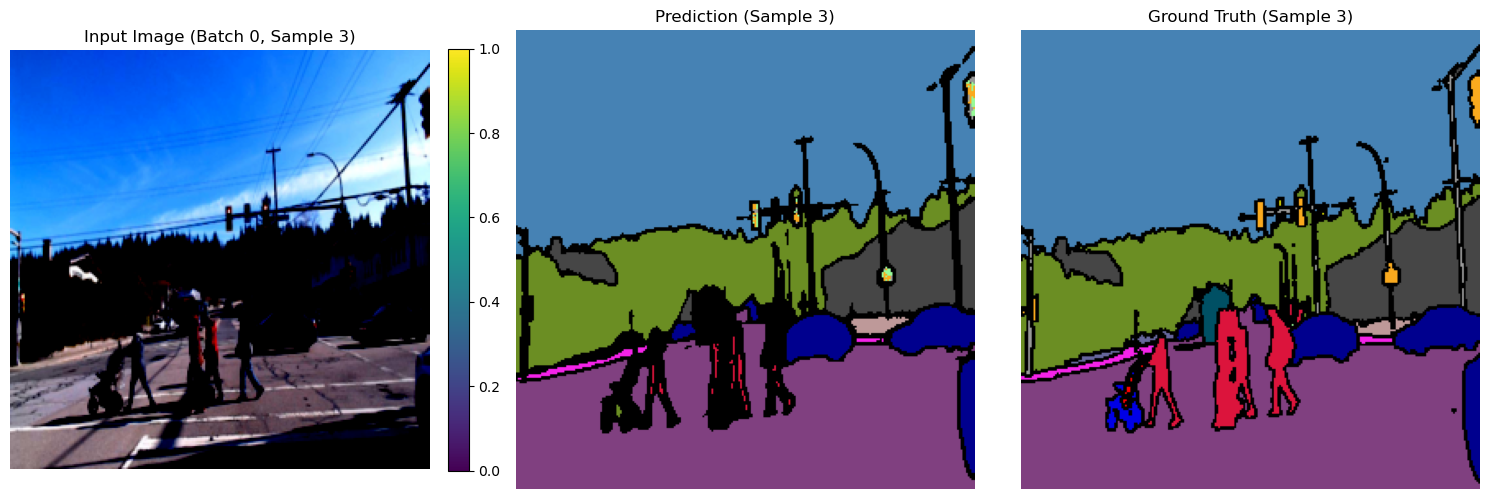

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


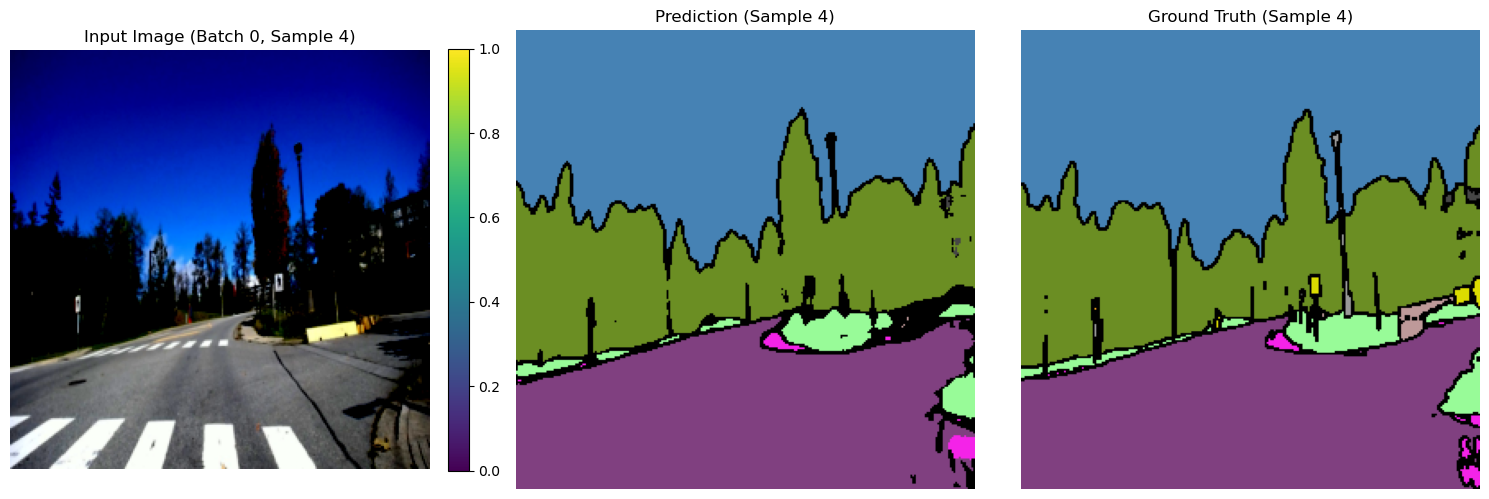

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


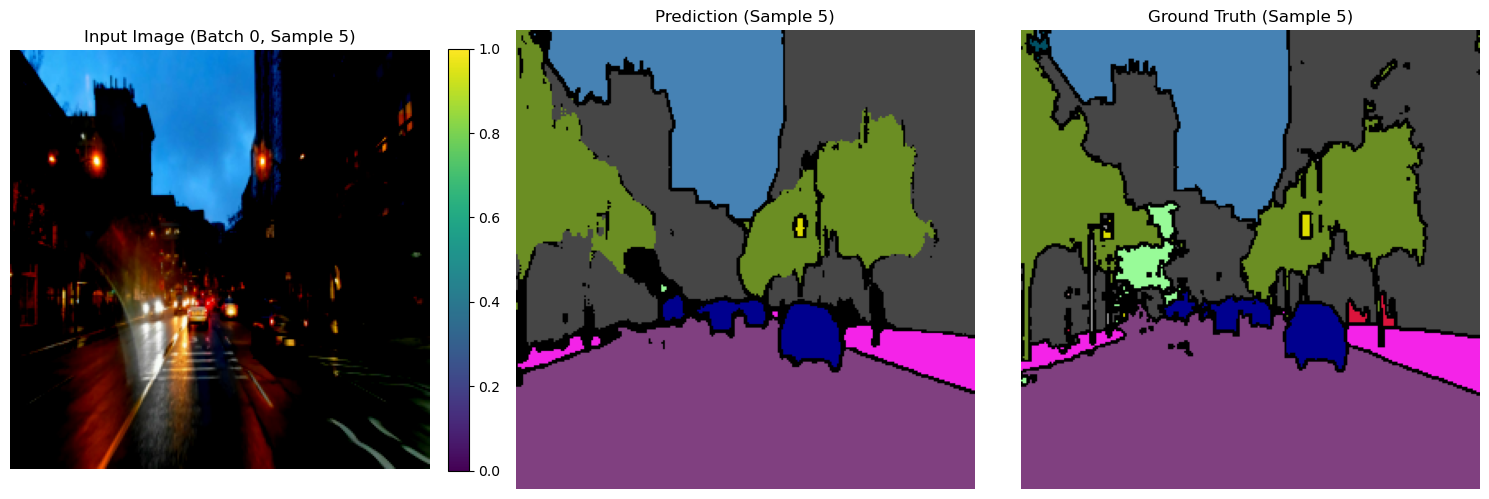

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


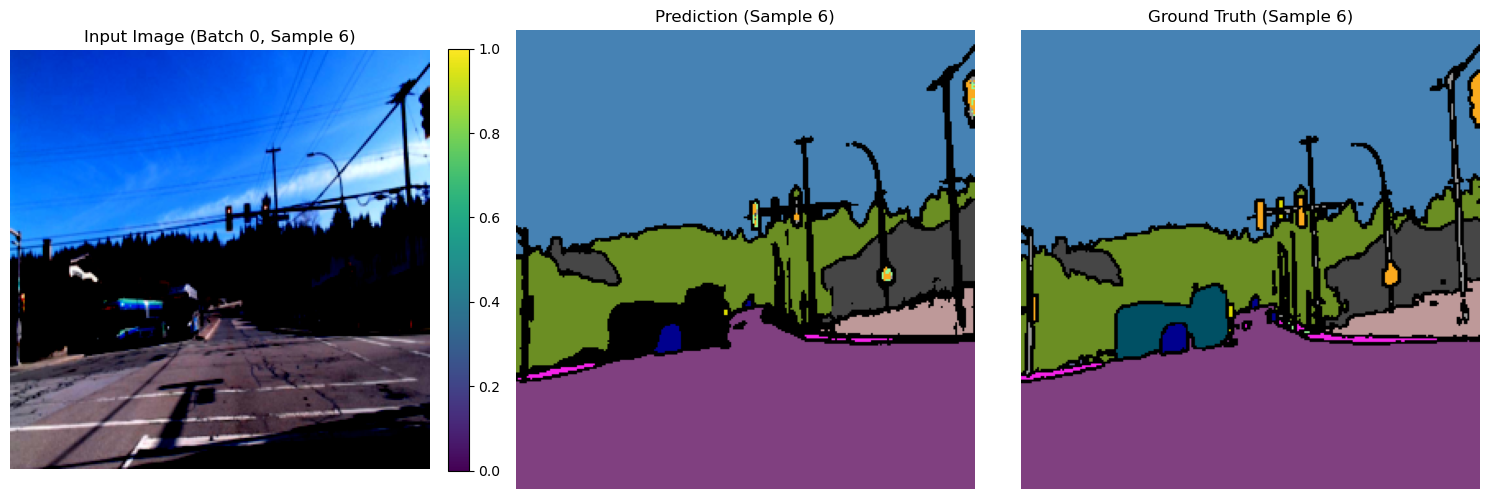

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


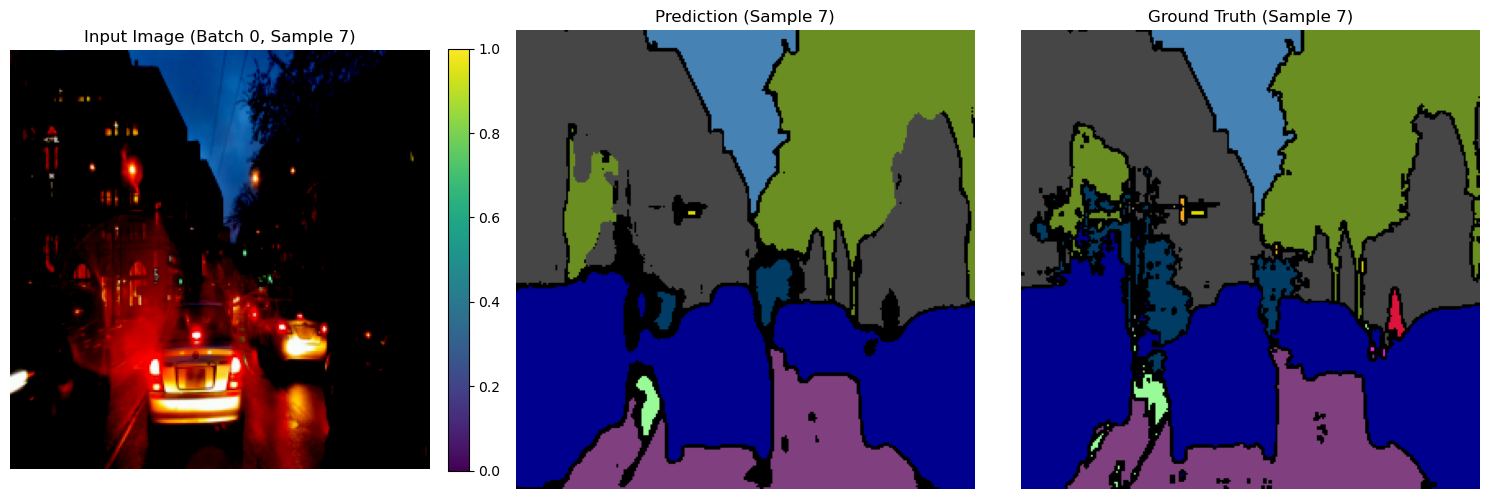

In [7]:
# Example: Visualizing predictions
for batch_idx, (inputs, targets, _) in enumerate(val_loader):
    with torch.no_grad():
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = model(inputs)
        predictions = torch.argmax(predictions, dim=1)  # Shape: [N, H, W]

        print(f"the shape of the targets is {targets.shape}")
        print(f"the shape of the inputs is {inputs.shape}")
        
        # Convert all predictions in the batch to RGB format
        rgb_predictions = np.stack([
            map_classes_to_colors(predictions[i].cpu().numpy(), class_to_color) for i in range(predictions.shape[0])
        ])  # Shape: [N, H, W, 3]
        

        rgb_targets = np.stack([
            map_classes_to_colors(targets[i].cpu().numpy(), class_to_color) for i in range(targets.shape[0])
        ])


    # Visualize the batch with RGB predictions
    visualize_batch_with_colorbar(inputs, rgb_predictions, rgb_targets, batch_idx, num_samples=8, rgb_pred=True)
    break

